# LP Problem

In [29]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [3]:
options = {
    "WLSACCESSID": "31598bc4-0b23-474f-86d4-af032d437137",
    "WLSSECRET": "bd7ad348-f8d6-452e-b615-ebc88d920e41",
    "LICENSEID": 2498404,
}

In [4]:
df = pd.read_csv('data_20180119_20180420.csv', index_col=0)
df.head()

,t0,T1,K1,C1,T2,K2,C2,S0,Adj_S0
0,2018-01-02,2018-01-19,1000.0,191.525,2018-04-20,800.0,396.725000,59.4505,1189.01001
1,2018-01-02,2018-01-19,1100.0,92.525,2018-04-20,1015.0,191.675000,59.4505,1189.01001
2,2018-01-02,2018-01-19,1150.0,46.075,2018-04-20,1025.0,183.025000,59.4505,1189.01001
3,2018-01-02,2018-01-19,1160.0,38.000,2018-04-20,1050.0,157.776341,59.4505,1189.01001
4,2018-01-02,2018-01-19,1170.0,30.450,2018-04-20,1080.0,137.850000,59.4505,1189.01001


## Optimization
Objective Function:

min $d+\sum_{n=1}^{N_1}\lambda_{n,1}\Pi_{n,1}+\sum_{n=1}^{N_2}\lambda_{n,2}\Pi_{n,2}$

Constrains:

$d+\sum_{n=1}^{N_1}\lambda_{n,1}(S_1^i-K_{n,1})^++\sum_{n=1}^{N_2}\lambda_{n,2}(S_2^j-K_{n,2})^++\Delta_{0}\cdot(S_1^i-S_0)+\Delta_{1}^i\cdot(S_2^j-S_1^i) \geq \Phi(S_1^i,S_2^j), i,j=1,...,N$

In [5]:
# initial payoff
def payoff(S1,S2):
    return max(S2 - S1, 0)

In [6]:
def data_per_day(df, date):
    df = df[df['t0'] == date]
    C1 = df['C1']
    C2 = df['C2']
    K1 = df['K1']
    K2 = df['K2']
    S0 = df['Adj_S0'].unique()
    return S0[0], C1, C2, K1, K2, df

In [14]:
# Generate Grid:
def generate_stock_grid(K, epsilon, n):
    S_min = min(K) - epsilon
    S_max = max(K) + epsilon
    return np.linspace(S_min, S_max, num=n+1)

In [22]:
# Optimization Model:
def opt_model(df, S0, S, C1, C2, K1, K2):
    m = gp.Model("Pricing Bounds")

    # Adding Variables:
    lamb1 = m.addVars(df.index, name="lamb1")
    lamb2 = m.addVars(df.index, name="lamb2")
    d = m.addVar(name="d")
    delta0 = m.addVar(name="delta0")
    delta1 = m.addVars(np.array(S[:, 0]).flatten(), name="delta1")


    # Setting the Objective Function:
    m.setObjective(d + sum(lamb1[r] * C1[r] + lamb2[r] * C2[r] for r in df.index), GRB.MINIMIZE)
    m.ModelSense = GRB.MINIMIZE

    # Adding Constraints:
    for S_i in S[:, 0]:
        for S_j in S[:, 1]:
            m.addConstr(
                d + sum(lamb1[r] * max(S_i - K1[r], 0) + lamb2[r] * max(S_j - K2[r], 0) for r in df.index)
                + delta0 * (S_i - S0) + delta1[S_i] * (S_j - S_i)
                >= payoff(S_i, S_j), 
                'C_{}{}'.format(S_i, S_j)
            )
            m.update()

    # Optimizing the Model:
    m.optimize()

    if m.status == GRB.OPTIMAL:
        var = {v.varName: v.x for v in m.getVars()}
        
        delta1_values = np.array([var['delta1[{}]'.format(s)] for s in S[:, 0]])
        delta1_interpolator = CubicSpline(S[:, 0], delta1_values)
        
        parameters[t0] = {
            'd': var['d'],
            'lamb1': {r: var['lamb1[{}]'.format(r)] for r in df_t0.index},
            'lamb2': {r: var['lamb2[{}]'.format(r)] for r in df_t0.index},
            'delta0': var['delta0'],
            'delta1': delta1_interpolator
        }
    else:
        print(f"Optimization was not successful for t0: {t0}")

    return m


## Try different t0

In [23]:
date_list = df['t0'].unique()
parameters = {}
N = 100
epsilon = 200

for t0 in date_list:
    
    S0, C1, C2, K1, K2, df_t0 = data_per_day(df, t0)
    
    S = np.zeros((N+1, 2))
    S[:, 0] = generate_stock_grid(K1, epsilon, N)
    S[:, 1] = generate_stock_grid(K2, epsilon, N)
    
    model = opt_model(df_t0, S0, S, C1, C2, K1, K2)
    print(parameters)
    print('===========')

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads


Consider calling update less frequently.

Optimize a model with 10201 rows, 143 columns and 220070 nonzeros
Model fingerprint: 0x70fed754
Coefficient statistics:
  Matrix range     [2e-13, 1e+03]
  Objective range  [8e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 4 rows and 0 columns
Presolve time: 0.10s
Presolved: 143 rows, 10197 columns, 219922 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.965e+03
 Factor NZ  : 4.949e+03 (roughly 4 MB of memory)
 Factor Ops : 2.272e+05

### Hedging Value VS Actual Value

In [24]:
def calculate_hedging_values(df, parameters, realS1, realS2):
    hList = []
    t0List = df['t0'].unique()
    
    for t0 in t0List:
        df_t0 = df.loc[df.t0 == t0].copy()
        K1 = df_t0['K1']
        K2 = df_t0['K2']
        
        h = (parameters[t0]['d']
             + sum(parameters[t0]['lamb1'][r] * max(realS1 - K1[r], 0) + 
                   parameters[t0]['lamb2'][r] * max(realS2 - K2[r], 0) for r in df_t0.index)
             + parameters[t0]['delta0'] * (realS1 - S0)
             + parameters[t0]['delta1'](realS1) * (realS2 - realS1)
            )
        hList.append(h)
    
    return hList


In [32]:
stocks = pd.read_csv('adjusted_stocks.csv')
realS1 = stocks.loc[stocks.Date=='2018-01-19', 'AMZN'].item()
realS2 = stocks.loc[stocks.Date=='2018-04-20', 'AMZN'].item()
stocks

,Date,AMZN,JPM,JNJ,MSFT,PG,WMT,GOOGL,V,TSLA
0,2018-01-02,1189.010010,90.125488,117.502670,80.080925,76.669670,88.322428,1073.209991,109.733635,320.530014
1,2018-01-03,1204.199982,90.217331,118.625122,80.453613,76.576607,89.092855,1091.520004,110.826103,317.249994
2,2018-01-04,1209.589996,91.509758,118.616730,81.161705,77.117928,89.173491,1095.759964,111.238144,314.619999
3,2018-01-05,1229.140015,90.922310,119.595680,82.167976,77.168678,89.702036,1110.289993,113.902199,316.580000
4,2018-01-08,1246.869965,91.056587,119.747589,82.251801,77.574646,91.027891,1114.209976,114.362175,336.410007
...,...,...,...,...,...,...,...,...,...,...
1561,2024-03-18,174.479996,192.660004,156.759995,417.320007,161.210007,60.860001,147.679993,285.049988,173.800003
1562,2024-03-19,175.899994,193.789993,156.210007,421.410004,161.830002,60.869999,147.029999,287.350006,171.320007
1563,2024-03-20,178.149994,196.330002,155.759995,425.230011,161.990005,61.250000,148.740005,289.279999,175.660004
1564,2024-03-21,178.149994,199.059998,155.750000,429.369995,161.860001,61.450001,147.600006,290.369995,172.820007


In [26]:
hList = calculate_hedging_values(df, parameters, realS1, realS2)
print(hList)

[333.32134234332193, 314.78657770174914, 286.4607788931086, 280.66511217816065, 287.4974437584075, 290.6337693555343, 294.13640030874103, 279.3841154832879, 283.3339208669678, 275.18299324277604, 272.30713886865175, 278.6862825781256, 277.043102313757]


In [27]:
h_minus_c = np.array(hList).flatten() - payoff(realS1, realS2)
h_minus_c

array([100.41133868,  81.87657404,  53.55077523,  47.75510852,
        54.5874401 ,  57.72376569,  61.22639665,  46.47411182,
        50.4239172 ,  42.27298958,  39.39713521,  45.77627892,
        44.13309865])

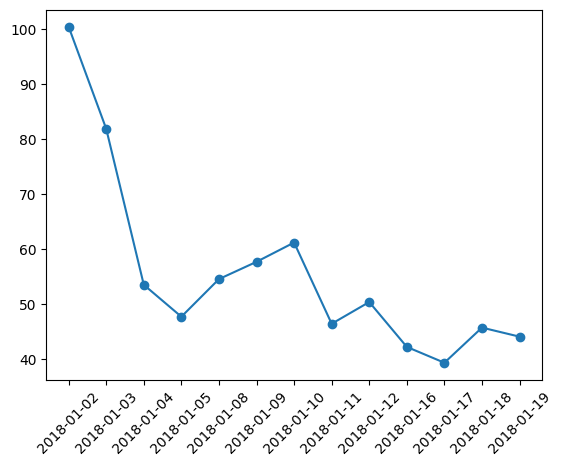

In [31]:
plt.plot(date_list, h_minus_c, '-o')
plt.xticks(rotation=45)
plt.show()

## Add Interest Rate